In [13]:
import gzip
import json
import warnings
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.preprocessing import OneHotEncoder
import timeit

In [14]:
#read the dataset
file_path_penguins ="penguins.csv"
data_set_penguins = pd.read_csv(file_path_penguins)
print(data_set_penguins.head())

  species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen              39.1             18.7                181   
1  Adelie  Torgersen              39.5             17.4                186   
2  Adelie  Torgersen              40.3             18.0                195   
3  Adelie  Torgersen              36.7             19.3                193   
4  Adelie  Torgersen              39.3             20.6                190   

   body_mass_g     sex  
0         3750    MALE  
1         3800  FEMALE  
2         3250  FEMALE  
3         3450  FEMALE  
4         3650    MALE  


In [15]:
#convert island and sex to 1-hot vectors 
island_one_hot = pd.get_dummies(data_set_penguins['island'], prefix='island')
sex_one_hot = pd.get_dummies(data_set_penguins['sex'], prefix='sex')
one_hot_vector = pd.concat([data_set_penguins,island_one_hot, sex_one_hot], axis=1)
one_hot_vector = one_hot_vector.drop(['island', 'sex'], axis=1)
print(one_hot_vector.head())
one_hot_vector.to_csv('one_hot_penguins.csv', index=False)

  species  culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  \
0  Adelie              39.1             18.7                181         3750   
1  Adelie              39.5             17.4                186         3800   
2  Adelie              40.3             18.0                195         3250   
3  Adelie              36.7             19.3                193         3450   
4  Adelie              39.3             20.6                190         3650   

   island_Biscoe  island_Dream  island_Torgersen  sex_FEMALE  sex_MALE  
0              0             0                 1           0         1  
1              0             0                 1           1         0  
2              0             0                 1           1         0  
3              0             0                 1           1         0  
4              0             0                 1           0         1  


In [16]:
# manual conversion using categorization
manual_cat = data_set_penguins
manual_cat['island'] = pd.Categorical(manual_cat['island']).codes
manual_cat['sex'] = pd.Categorical(manual_cat['sex']).codes
print(manual_cat.head())
manual_cat.to_csv('manual_cat_penguins.csv', index=False)

  species  island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie       2              39.1             18.7                181   
1  Adelie       2              39.5             17.4                186   
2  Adelie       2              40.3             18.0                195   
3  Adelie       2              36.7             19.3                193   
4  Adelie       2              39.3             20.6                190   

   body_mass_g  sex  
0         3750    1  
1         3800    0  
2         3250    0  
3         3450    0  
4         3650    1  


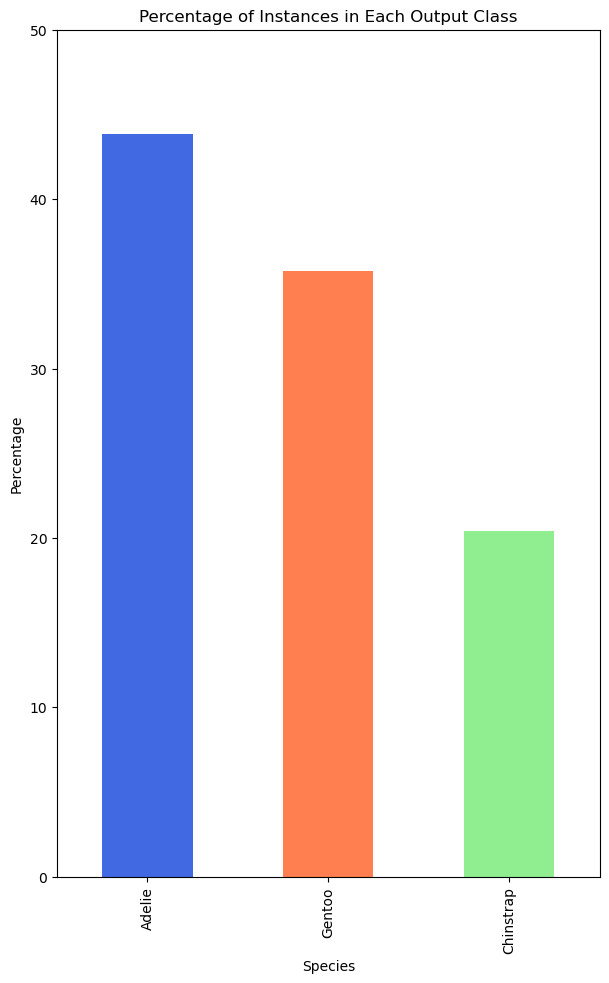

In [49]:
# plotting the % using one_hot_vector
plot = one_hot_vector
class_counts = plot['species'].value_counts()
class_percentages = (class_counts / len(plot)) * 100
colors = ['royalblue', 'coral', 'lightgreen']
plt.figure(figsize=(7, 11))
class_percentages.plot(kind='bar', color=colors)
plt.title('Percentage of Instances in Each Output Class')
plt.xlabel('Species')
plt.ylabel('Percentage')
plt.ylim(0, 50)
plt.savefig('penguin-classes.jpg')